In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns
from scipy import stats

from statsmodels.stats import multitest
import ptitprince as pt
import copy

In [3]:
import popoff
import pop_off_plotting as pop
from pop_off_plotting import color_tt
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape


In [4]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)

long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [5]:
# globals()

hit s1
Grand average max value:  0.0383106972949217 pm  0.003875541027206393 at time  0.36666666666666664
---
miss s1
Grand average max value:  0.015454600118250034 pm  0.004233384483738096 at time  0.36666666666666664
---
fp s1
Grand average max value:  0.011384659316536677 pm  0.005184718434411554 at time  0.6666666666666666
---
cr s1
Grand average max value:  0.003766418384417976 pm  0.003980705201257312 at time  3.8333333333333335
---
pre_reward s1
Grand average max value:  0.02022193600195279 pm  0.007551747219995282 at time  1.2333333333333334
---
hit s2
Grand average max value:  0.021502394839475664 pm  0.006359144469370377 at time  0.36666666666666664
---
miss s2
Grand average max value:  0.010499500301299357 pm  0.007158209497685112 at time  0.8
---
fp s2
Grand average max value:  0.02216570018527781 pm  0.008525386120829365 at time  0.5333333333333333
---
cr s2
Grand average max value:  0.004483423346736194 pm  0.0035712122025325864 at time  -0.8666666666666667
---
pre_reward

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

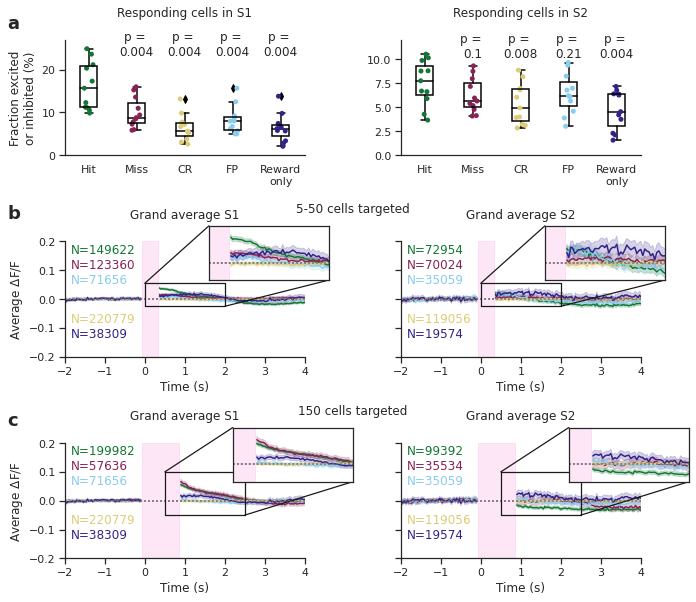

In [7]:
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
save_fig = True

tts = ['hit', 'miss', 'fp', 'cr', 'pre_reward']

rains = fig.add_gridspec(ncols=2, nrows=1, bottom=0.8, top=1, right=1, left=0,
                            wspace=0.4, hspace=0.85)
without_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.45, top=0.65, right=1, left=0,
                               wspace=0.4, hspace=0.85)
only_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.1, top=0.3, right=1, left=0,
                            wspace=0.4, hspace=0.85)

fig.text(0.5, 0.7, '5-50 cells targeted', ha="center")
fig.text(0.5, 0.35, '150 cells targeted', ha="center")

## b, c
ax_pop_activity_wo = {xx: fig.add_subplot(without_150[xx]) for xx in range(2)}

for n_cells in [[5, 10, 20, 30, 40, 50]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity_wo[0], ax_s2=ax_pop_activity_wo[1],
                                   plot_legend=(n_cells == 50))
    
ax_pop_activity_wo[0].set_title('Grand average S1', y=1.15)
ax_pop_activity_wo[1].set_title('Grand average S2', y=1.15)
    
## d, e    
ax_pop_activity_150 = {xx: fig.add_subplot(only_150[xx]) for xx in range(2)}

for n_cells in [[150]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity_150[0], ax_s2=ax_pop_activity_150[1],
                                   plot_legend=False, zoom_ylims=(-0.05, 0.1))
    
ax_pop_activity_150[0].set_title('Grand average S1', y=1.15)
ax_pop_activity_150[1].set_title('Grand average S2', y=1.15)

## a
ax_rains = [fig.add_subplot(rains[xx]) for xx in range(2)]
pop.despine(ax_rains[0])
pop.despine(ax_rains[1])

pop.percent_responding_tts(lm_list=msm.linear_models, axes=ax_rains,
                           bonf_correction=8,
                           alternative_hypothesis='greater')  # use 'two-sided' or 'greater' for one-sided that hit is greater than other tts 

ax_rains[0].set_title('Responding cells in S1', y=1.15)
ax_rains[1].set_title('Responding cells in S2', y=1.15)

fig.text(s='a', x=-0.1, y=1.02, fontdict={'weight': 'bold', 'size': 18})
fig.text(s='b', x=-0.1, y=0.69, fontdict={'weight': 'bold', 'size': 18})
fig.text(s='c', x=-0.1, y=0.33, fontdict={'weight': 'bold', 'size': 18})

if save_fig:
    # plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure1.pdf',
    #             bbox_inches='tight')
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure1.eps',
                bbox_inches='tight', format='eps')